In [1]:
## libraries for the unet model
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

# IMPORTS

In [2]:
import segmentation_models_pytorch as smp
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as T
import albumentations as album
import cv2
from torchvision.transforms import ToPILImage as to_PIL
import warnings
warnings.filterwarnings('ignore')


# CONFIGURATIONS (GLOBAL VARIABLES)

In [3]:
class config:
    SEEDS = 42
    BATCH_SIZE = 8
    NUM_CLASSES = 3
    epochs = 10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# META DATA PREPARATION :(Necessary Functions)

In [4]:
##_______________________________________________META DATA PREPROCESSING FUNCTIONS_______________________________________________________________
def get_case_day_silce_from_id(df):
    df['case_id'] = df['id'].apply(lambda x: x.split('_')[0][4:])
    df['day_id'] = df['id'].apply(lambda x: x.split('_')[1][3:])
    df['slice_id'] = df['id'].apply(lambda x: x.split('_')[-1])
    return df
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split('_')[0]
    day_folder = '_'.join(case_id.split('_')[:2])
    file_starter = '_'.join(case_id.split('_')[2:])
    folder = os.path.join(root_dir, case_folder, day_folder, 'scans')
    file = glob(f'{folder}/{file_starter}*')
    return file[0]
def preprocess_metadata(root_dir, df):
    df['segmentation'] = df['segmentation'].astype('str') 
    df = get_case_day_silce_from_id(df)
    df['path'] = df['id'].apply(lambda x: fetch_file_from_id(root_dir, x))
    df['height'] = df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[2]).astype('int')
    df['width'] = df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[3]).astype('int')
    class_names = df['class'].unique()
    for ind, label in enumerate(class_names):
        df['class'].replace(label, ind, inplace=True)
    return df



# DATASET PREPARATION: (MASK GENERATION & IMAGE)
* process the image data shapes form the image ids.
* Process mask from RLE format.

In [19]:
##---------------------------------------------------Preprare DATASET CLASS ------------------------------------------------------------------

#Inherited from pytorch's Datatset class. (torch.utils.data)
class UWDataset(Dataset):
    def __init__(self, meta_df, H = 256, W = 256, preprocessing = None):
        super().__init__()
        self.meta_df = meta_df
        self.h = H
        self.w = W
        self.resize = Resize((H,W))
        self.preprocessing = preprocessing #recommended to preprocess the data as the data format the unet model was pretrained to get more accurate results
    def __len__(self):
        return len(self.meta_df)
    def __getitem__(self, index):
        path = self.meta_df.loc[index, 'path']
        image = self.load_image(path)
        mask_h, mask_w = self.meta_df.loc[index, 'height'], self.meta_df.loc[index, 'width']
        mask_string = self.meta_df.loc[index, 'segmentation']
        mask_channel = self.load_mask(string = mask_string, h= mask_h, w = mask_w)
#         if self.preprocessing:
#             image, mask_channel = np.array(image),np.array(mask_channel)
#             sample = self.preprocessing(image= image, mask = mask_channel)
#             image, mask_channel = Image.fromarray(sample['image']),Image.fromarray(sample['mask'])
        image = ToTensor()(self.resize(image))
        mask_channel = ToTensor()(self.resize(mask_channel))
        mask = torch.zeros((3, self.h, self.w))
        class_label = self.meta_df.loc[index, 'class']
        mask[class_label, ...] = mask_channel
        #mask = mask_channel
        if self.preprocessing:
            image, mask = np.array(image),np.array(mask)
            sample = self.preprocessing(image= image, mask = mask)
            image, mask = sample['image'],sample['mask']
            print(f'Shapes: {image.shape} , {mask.shape}')
            
#             mask = (mask / 255).astype(np.float32)
#             mask = np.expand_dims(mask, axis=0)
#             image = (image / 255).astype(np.float32)
#             image = np.expand_dims(image, axis=0)
        return image, mask
    def prepare_mask_data(self,string):
        all_values = map(int, string.split(' '))
        start_indx, pixel_counts = [], []
        for i, value in enumerate(all_values):
            if i%2==0:
                start_indx.append(value)
            else:
                pixel_counts.append(value)
        return start_indx, pixel_counts
    def fetch_pos_pixel_indexes(self, indexes, counts):
        final_Arr = []
        for ind,count in zip(indexes, counts):
            final_Arr += [ind + i for i in range(count)]
        return final_Arr
    
    def load_mask(self, string, h, w):
        if string != 'nan':
            return Image.fromarray(self.prepare_mask(string=string, h=h, w=w))
            #return prepare_mask(string, h, w)
        return Image.fromarray(np.zeros((h,w)))
    def prepare_mask(self, string, h,w):
        indexes, counts = self.prepare_mask_data(string=string)
        pos_pixel_indexes = self.fetch_pos_pixel_indexes(indexes, counts)
        mask_arr = np.zeros(h*w)
        mask_arr[pos_pixel_indexes] = 1
        return mask_arr.reshape(h,w)
    def load_image(self, path):
        return Image.open(path).convert('RGB')
        #return np.zeros((h,w))
    
def to_tensor(self, x, **kwargs):
        return ToTensor()(Resize(x))
    
def get_preprocessing(preprocessing_fn):
    transform = [
    album.Lambda(image = preprocessing_fn),
    album.Lambda(image = to_tensor, mask = to_tensor)
    ]
    return album.Compose(transform)
#------------------------------------------------------------SHOW IMAGE----------------------------------------------------
def show_image(image_tensor, name):
    plt.figure(figsize= (20,20))
    plt.imshow(image_tensor.permute(1,2,0))
    plt.title(name, size =30)
    plt.show()
def show_batch(image_batch, mask_batch, name):
    image_mask_batch = torch.cat([make_grid(image_batch, nrows = 8), make_grid(mask_batch, nrows = 8)], dim = 2)
    show_image(image_mask_batch, name)




# TRAIN TEST SPLIT FUNCTION FOR TRAINING PROCESS
1. Train_Test_split the metadata
2. Load the train_validation(test) data batches that will be fed to train the model using DataLoader

In [6]:
def train_test_split(ds, test_size=0.2):
    test_size = int(test_size*len(ds))
    train_size = len(ds) - test_size
    train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, test_size], generator = torch.Generator().manual_seed(config.SEEDS))
    print(f'Length of training split: {len(train_ds)}')
    print(f'Length of validation split: {len(val_ds)}')
    train_dl = DataLoader(train_ds, batch_size = config.BATCH_SIZE, shuffle = True, drop_last = True)
    val_dl = DataLoader(val_ds, batch_size = config.BATCH_SIZE, shuffle = True, drop_last = True)
    return train_dl, val_dl

## 1. Define training data and metadata directories

In [7]:
## Define the training and metadata pathes
train_dir = '/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-image-segmentation/train'
train_metadata_dir = '/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-image-segmentation/train.csv'

## 2. Read training metadata data frame

In [8]:
train_df = pd.read_csv(train_metadata_dir)
train_df.head()


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


## 3. Preprocessing metadata data frame: 
1. Convert NANs to string 
2. Get case, day and slice ids from id column
3. fetch files from id and create a path column
4. get the shape of each slice from path and implement them in the metadata
5. perform label encoding to the class names in class columns

In [9]:
train_df = preprocess_metadata(train_dir, train_df)
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id,path,height,width
0,case123_day20_slice_0001,0,nan,123,20,0001,/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-...,266,266
1,case123_day20_slice_0001,1,nan,123,20,0001,/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-...,266,266
2,case123_day20_slice_0001,2,nan,123,20,0001,/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-...,266,266
3,case123_day20_slice_0002,0,nan,123,20,0002,/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-...,266,266
4,case123_day20_slice_0002,1,nan,123,20,0002,/home/human/WADDAH/KAGGLE/uw-madison-gi-tract-...,266,266


## 4. Load the training data using training metadata dataframe

In [10]:
ds = UWDataset(train_df)
print(f"Length of the dataset : {len(ds)}")

Length of the dataset : 115488


In [11]:
image, mask = ds[194]
image.shape, mask.shape

Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])


(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [12]:
combined_im_mask = torch.cat((image, mask), dim=2)

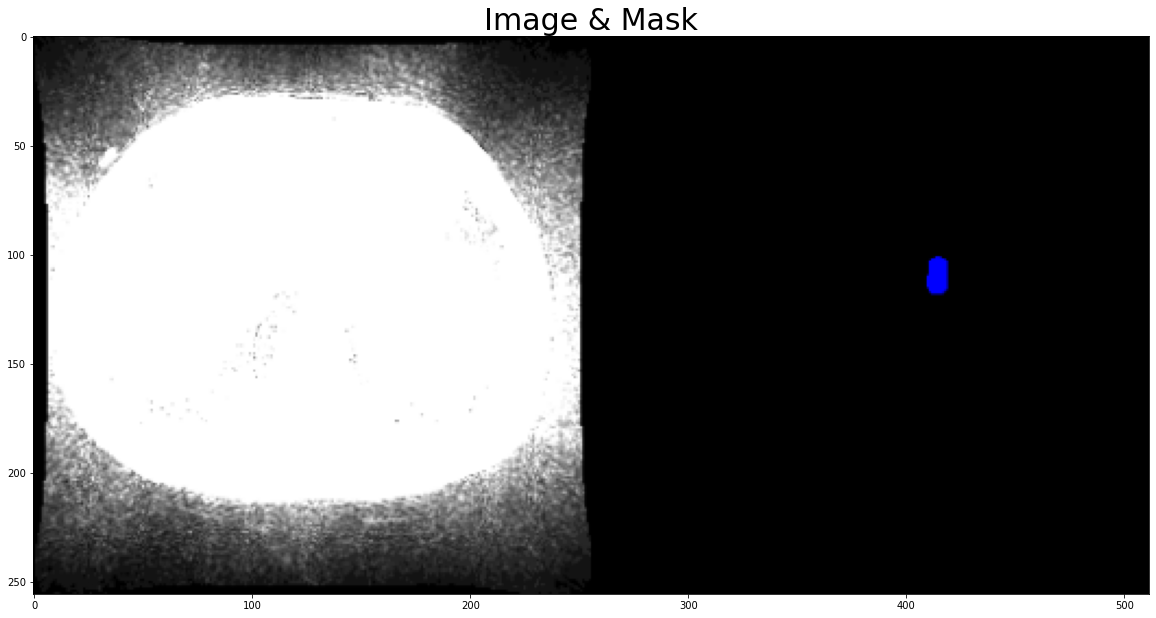

In [13]:
show_image(combined_im_mask, 'Image & Mask')

## 5. split loaded data to training and validation splits:


In [14]:
## split data to training and validation splits:
train_dl, val_dl = train_test_split(ds, test_size =0.2)

Length of training split: 92391
Length of validation split: 23097


## 6. visualization of one batch of training data and validation data

Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])
Shapes: torch.Size([3, 256, 256]) , torch.Size([3, 256, 256])


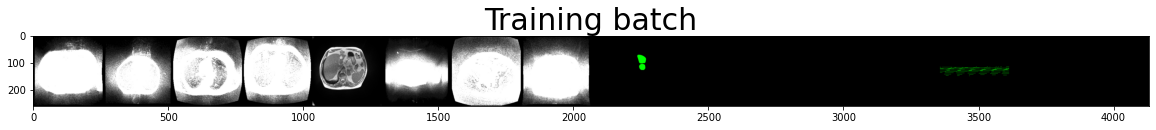

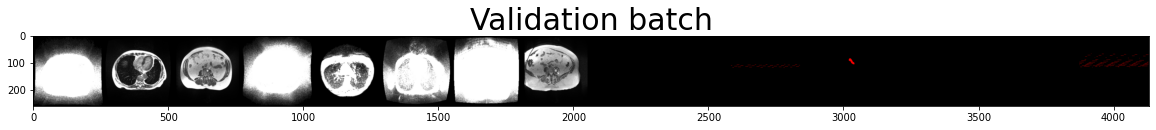

In [15]:
for train_image_dl, train_mask_dl in train_dl:
    break
for val_image_dl, val_mask_dl in val_dl:
    break
show_batch(train_image_dl,train_mask_dl, 'Training batch')
show_batch(val_image_dl, val_mask_dl, 'Validation batch')

## 7. load the Unet model to be trained on the loaded data

In [20]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = train_df['class'].unique()
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### preprocessing and loading data for the unet model

In [21]:

ds_unet = UWDataset(train_df, preprocessing = get_preprocessing(preprocessing_fn))
print(f"Length of the dataset : {len(ds)}")

Length of the dataset : 115488


In [22]:
im , msk = ds_unet[2]
im.shape, msk.shape

ValueError: operands could not be broadcast together with shapes (3,256,256) (3,) 

In [142]:
## split data to training and validation splits:
train_unet_dataset, test_unet_dataset = train_test_split(ds_unet, test_size =0.2)


Length of training split: 92391
Length of validation split: 23097


### Hyperparameters

In [143]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = config.epochs

# Set device: `cuda` or `cpu`
DEVICE = config.device

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/home/human/WADDAH/KAGGLE/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('/home/human/WADDAH/KAGGLE/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [144]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [145]:
#pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu110/torch_nightly.html -U

In [146]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_unet_dataset)
        valid_logs = valid_epoch.run(test_unet_dataset)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|                                                                                  | 0/11548 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (3,256,256) (3,) 

In [24]:
print(torch.__version__)

1.8.0


In [25]:
# import torch
import sys
print('A', sys.version)
print('B', torch.__version__)
print('C', torch.cuda.is_available())
print('D', torch.backends.cudnn.enabled)
device = torch.device('cuda')
print('E', torch.cuda.get_device_properties(device))
print('F', torch.tensor([1.0, 2.0]).cuda())

A 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
B 1.8.0
C True
D True
E _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=9984MB, multi_processor_count=68)
F tensor([1., 2.], device='cuda:0')
